In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Import Data

In [12]:
# Load the data
file_path = 'LOL.csv'
data = pd.read_csv(file_path)
data.Region.fillna('NA', inplace = True)

# Converting multiple columns to boolean format in a more concise way
columns_to_convert = ['TOP_KR', 'JG_KR', 'MID_KR', 'BOT_KR', 'SUP_KR', 'Has_KR', 'KR_to_non', 'non_to_KR']
data[columns_to_convert] = data[columns_to_convert].apply(lambda x: x > 0)

display(data)

,Name,Season,Region,Win_rate,Split,TOP_KR,JG_KR,MID_KR,BOT_KR,SUP_KR,KR,Has_KR,KR_to_non,non_to_KR,change,d_win_rate
0,100 Thieves,S13,NA,0.348,Summer,True,False,True,False,False,2,True,False,True,2.0,-0.152
1,100 Thieves,S13,NA,0.500,Spring,False,False,False,False,False,0,False,True,False,-2.0,-0.100
2,100 Thieves,S12,NA,0.600,Summer,True,False,False,False,True,2,True,False,False,0.0,0.000
3,100 Thieves,S12,NA,0.600,Spring,True,False,False,False,True,2,True,False,False,0.0,-0.059
4,100 Thieves,S11,NA,0.659,Summer,True,False,False,False,True,2,True,False,False,0.0,0.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,Victory Five,S9,CN,0.361,Spring,True,False,False,False,False,1,True,False,False,NaN,-0.271
432,Weibo Gaming,S13,CN,0.632,Summer,True,False,False,False,False,1,True,False,False,0.0,0.037
433,Weibo Gaming,S13,CN,0.595,Spring,True,False,False,False,False,1,True,False,False,0.0,0.062
434,Weibo Gaming,S12,CN,0.533,Summer,True,False,False,False,False,1,True,False,False,0.0,-0.050


In [77]:
# Calculate the average win rate for teams with Korean players
average_win_rate_with_kr = data[data['Has_KR']]['Win_rate'].mean()
print(f"有韓國隊員的隊伍的平均勝率為 {average_win_rate_with_kr*100:.2f}%")

# Calculate the average win rate for different numbers of Korean players
average_win_rate_by_kr_count = data.groupby('KR')['Win_rate'].mean()
print(f"根據韓國隊員的不同數量 (0至3個) 平均勝率為 {average_win_rate_by_kr_count[0]*100:.2f}%、{average_win_rate_by_kr_count[1]*100:.2f}%、{average_win_rate_by_kr_count[2]*100:.2f}%、{average_win_rate_by_kr_count[3]*100:.2f}%")

有韓國隊員的隊伍的平均勝率為 49.25%
根據韓國隊員的不同數量 (0至3個) 平均勝率為 46.04%、43.72%、56.84%、51.93%


## Matching

In [78]:
# Calculate the difference win rate between teams with and without korean
average_win_rate_wo_kr = data[~data['Has_KR']]['Win_rate'].mean()
diff_win_rate_with_kr = average_win_rate_with_kr - average_win_rate_wo_kr
print(f"有韓國隊員的隊伍的平均增加勝率 {diff_win_rate_with_kr*100:.2f}%")

有韓國隊員的隊伍的平均增加勝率 3.21%


Matching Season 後，有韓國隊員的隊伍的平均增加勝率 3.18%


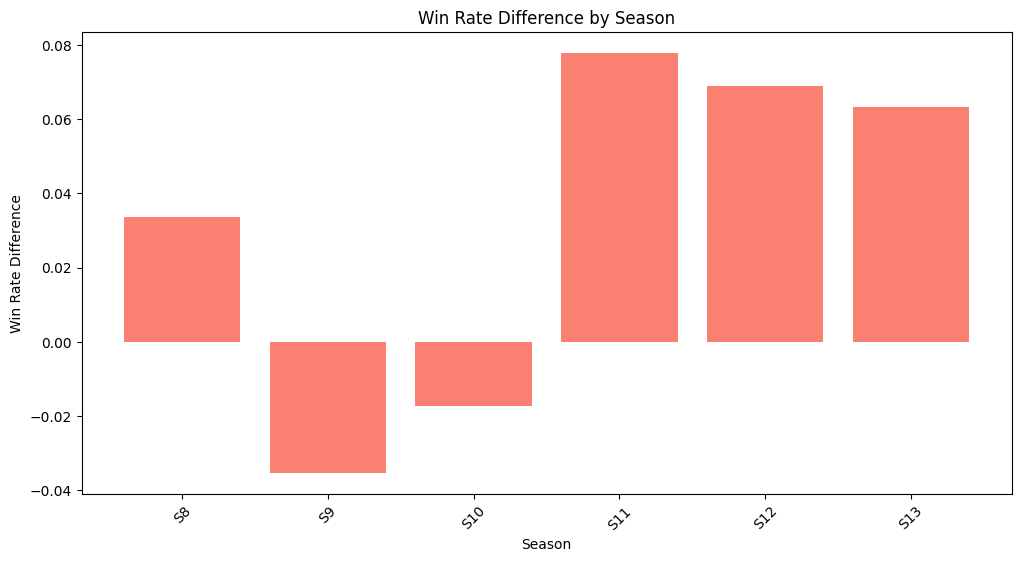

In [79]:
# Step 1: Calculate the average win rate in each season for teams with and without Korean players
win_rate_with_kr_season = data[data['Has_KR']].groupby('Season')['Win_rate'].mean()
win_rate_without_kr_season = data[~data['Has_KR']].groupby('Season')['Win_rate'].mean()

# Step 2: Calculate the difference in win rate for each season
win_rate_difference_season = win_rate_with_kr_season - win_rate_without_kr_season

# Step 3: Calculate the average of these differences across the seasons
average_difference_across_seasons = win_rate_difference_season.mean()

print(f"Matching Season 後，有韓國隊員的隊伍的平均增加勝率 {average_difference_across_seasons*100:.2f}%")

# Creating a DataFrame for easier visualization
win_rate_diff_df_season = pd.DataFrame({
    'Season': win_rate_difference_season.index,
    'Win_Rate_Difference': win_rate_difference_season.values
})

# The seasons need to be sorted numerically, but they are strings. We'll extract the numeric part for sorting.
win_rate_diff_df_season['Season_Sort'] = win_rate_diff_df_season['Season'].str.extract('(\d+)').astype(int)
win_rate_diff_df_season = win_rate_diff_df_season.sort_values('Season_Sort')

# Dropping the helper column used for sorting
win_rate_diff_df_season.drop('Season_Sort', axis=1, inplace=True)

# Plotting for Region
plt.figure(figsize=(12, 6))
plt.bar(win_rate_diff_df_season['Season'], win_rate_diff_df_season['Win_Rate_Difference'], color='salmon')
plt.title('Win Rate Difference by Season')
plt.xlabel('Season')
plt.ylabel('Win Rate Difference')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

Matching Region 後，有韓國隊員的隊伍的平均增加勝率 1.71%


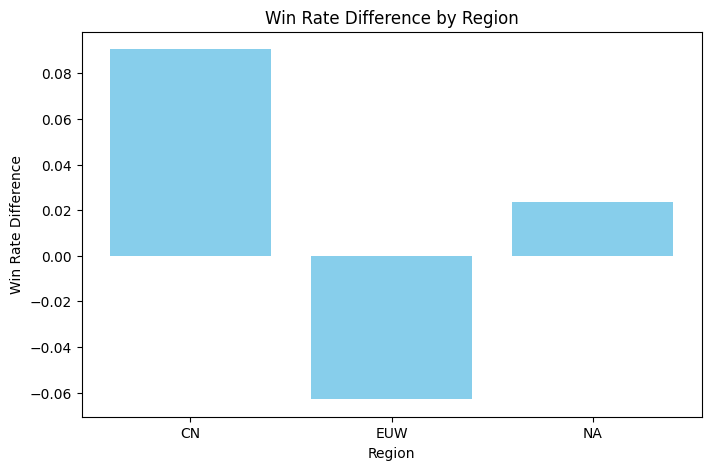

In [80]:
# Similar analysis for Region
win_rate_with_kr_region = data[data['Has_KR']].groupby('Region')['Win_rate'].mean()
win_rate_without_kr_region = data[~data['Has_KR']].groupby('Region')['Win_rate'].mean()
win_rate_difference_region = win_rate_with_kr_region - win_rate_without_kr_region
average_difference_across_regions = win_rate_difference_region.mean()

print(f"Matching Region 後，有韓國隊員的隊伍的平均增加勝率 {average_difference_across_regions*100:.2f}%")

win_rate_diff_df_region = pd.DataFrame({
    'Region': win_rate_difference_region.index,
    'Win_Rate_Difference': win_rate_difference_region.values
})

plt.figure(figsize=(8, 5))
plt.bar(win_rate_diff_df_region['Region'], win_rate_diff_df_region['Win_Rate_Difference'], color='skyblue')
plt.title('Win Rate Difference by Region')
plt.xlabel('Region')
plt.ylabel('Win Rate Difference')
plt.show()

Matching Split 後，有韓國隊員的隊伍的平均增加勝率 3.21%


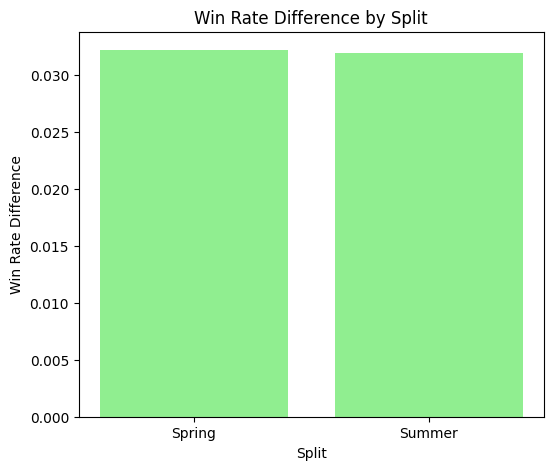

In [81]:
# Similar analysis for Split
win_rate_with_kr_split = data[data['Has_KR']].groupby('Split')['Win_rate'].mean()
win_rate_without_kr_split = data[~data['Has_KR']].groupby('Split')['Win_rate'].mean()
win_rate_difference_split = win_rate_with_kr_split - win_rate_without_kr_split
average_difference_across_splits = win_rate_difference_split.mean()

print(f"Matching Split 後，有韓國隊員的隊伍的平均增加勝率 {average_difference_across_splits*100:.2f}%")

win_rate_diff_df_split = pd.DataFrame({
    'Split': win_rate_difference_split.index,
    'Win_Rate_Difference': win_rate_difference_split.values
})

plt.figure(figsize=(6, 5))
plt.bar(win_rate_diff_df_split['Split'], win_rate_diff_df_split['Win_Rate_Difference'], color='lightgreen')
plt.title('Win Rate Difference by Split')
plt.xlabel('Split')
plt.ylabel('Win Rate Difference')
plt.show()

Matching Season and Region 後，有韓國隊員的隊伍的平均增加勝率 2.26%


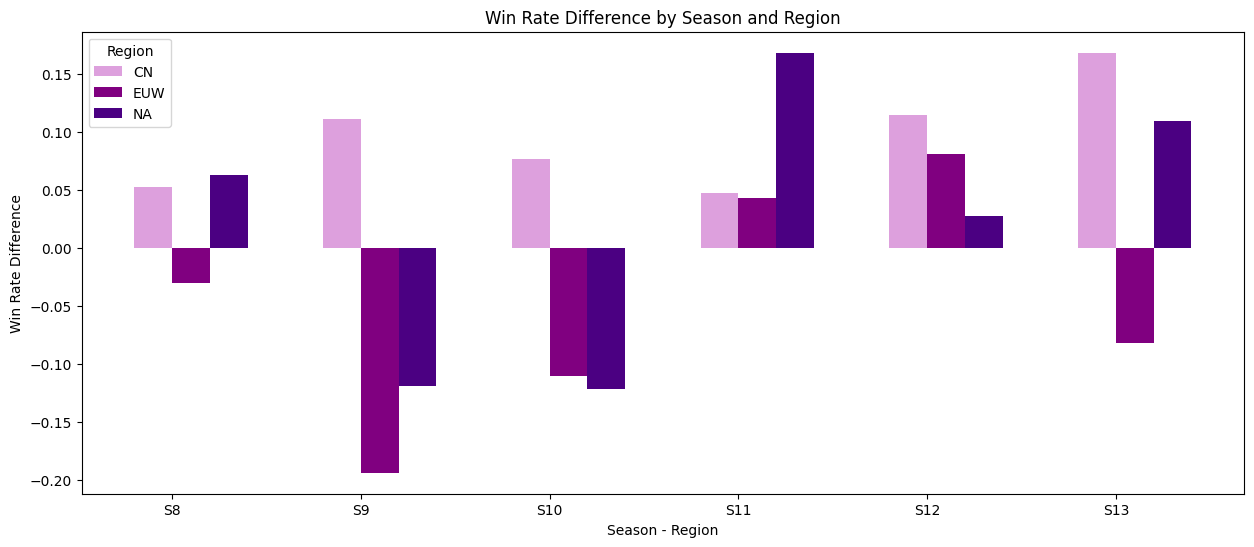

In [82]:
# Step 1: Calculate the average win rate in each season and region for teams with and without Korean players
win_rate_with_kr_season_region = data[data['Has_KR']].groupby(['Season', 'Region'])['Win_rate'].mean()
win_rate_without_kr_season_region = data[~data['Has_KR']].groupby(['Season', 'Region'])['Win_rate'].mean()

# Step 2: Calculate the difference in win rate for each season and region
win_rate_difference_season_region = win_rate_with_kr_season_region - win_rate_without_kr_season_region

# Step 3: Calculate the average of these differences across the seasons and regions
average_difference_across_seasons_regions = win_rate_difference_season_region.mean()

print(f"Matching Season and Region 後，有韓國隊員的隊伍的平均增加勝率 {average_difference_across_seasons_regions*100:.2f}%")

# Creating a DataFrame for easier visualization
win_rate_diff_df_season_region = pd.DataFrame(win_rate_difference_season_region).reset_index()
win_rate_diff_df_season_region['Season_Sort'] = win_rate_diff_df_season_region['Season'].str.extract('(\d+)').astype(int)
win_rate_diff_df_season_region = win_rate_diff_df_season_region.sort_values(['Season_Sort', 'Region'])

# Dropping the helper column used for sorting
win_rate_diff_df_season_region.drop('Season_Sort', axis=1, inplace=True)

# To improve readability, we will separate the bars for each season more distinctly
unique_seasons = win_rate_diff_df_season_region['Season'].unique()
colors = ['plum', 'purple', 'indigo']  # Alternate colors for different regions within a season
bar_width = 0.2  # Width of the bars
gap_width = 1  # Distance between different seasons

plt.figure(figsize=(15, 6))

# Plot each season separately with adjusted gap between different seasons
for i, season in enumerate(unique_seasons):
    # Filter data for the season
    season_data = win_rate_diff_df_season_region[win_rate_diff_df_season_region['Season'] == season]
    
    # Create bar positions for this season
    bar_positions = [i * gap_width + j * bar_width for j in range(len(season_data))]
    
    # Plot bars for each region within the season
    for j, region in enumerate(season_data['Region']):
        plt.bar(bar_positions[j],
                season_data['Win_rate'].iloc[j],
                color=colors[j],
                width=bar_width,
                label=region if i == 0 else "")

plt.title('Win Rate Difference by Season and Region')
plt.xlabel('Season - Region')
plt.ylabel('Win Rate Difference')
plt.xticks([i * gap_width + bar_width / 2 for i in range(len(unique_seasons))], unique_seasons)
plt.legend(title="Region")
plt.show()

## DID

In [93]:
# Step 1: Calculate the average win rate (A) for the treatment group after treatment
avg_win_rate_treatment_post = data[data['non_to_KR']]['Win_rate'].mean()

# Step 2: Calculate the average win rate (B) for the treatment group before treatment
# We need to shift the 'Win_rate' column to get the previous win rate for rows where 'non_to_KR' is TRUE
data['Prev_Win_rate'] = data['Win_rate'].shift(-1)
avg_win_rate_treatment_pre = data[data['non_to_KR']]['Prev_Win_rate'].mean()

# Step 3: Calculate the average win rate (C) for the control group after treatment
avg_win_rate_control_post = data[~data['non_to_KR']]['Win_rate'].mean()

# Step 4: Calculate the average win rate (D) for the control group before treatment
# We need to shift the 'Win_rate' column to get the previous win rate for rows where 'non_to_KR' is FALSE
avg_win_rate_control_pre = data[~data['non_to_KR']]['Prev_Win_rate'].mean()

# Step 5: Present the results in a 2x2 matrix
results_matrix = pd.DataFrame({
    'Pre-Treatment': [avg_win_rate_treatment_pre, avg_win_rate_control_pre],
    'Post-Treatment': [avg_win_rate_treatment_post, avg_win_rate_control_post]
}, index=['Treatment Group', 'Control Group'])

# Difference within Treatment Group (Post - Pre)
diff_within_treatment = results_matrix.loc['Treatment Group', 'Post-Treatment'] - results_matrix.loc['Treatment Group', 'Pre-Treatment']
diff_within_control = results_matrix.loc['Control Group', 'Post-Treatment'] - results_matrix.loc['Control Group', 'Pre-Treatment']

# Difference between groups (Treatment - Control) for Pre and Post
diff_between_pre = results_matrix.loc['Treatment Group', 'Pre-Treatment'] - results_matrix.loc['Control Group', 'Pre-Treatment']
diff_between_post = results_matrix.loc['Treatment Group', 'Post-Treatment'] - results_matrix.loc['Control Group', 'Post-Treatment']

# Adding the calculated differences to the matrix
results_matrix_extended = results_matrix.copy()
results_matrix_extended.loc['Difference Between', :] = [diff_between_pre, diff_between_post]
results_matrix_extended.loc[:, 'Difference Within'] = [diff_within_treatment, diff_within_control, diff_within_treatment - diff_within_control]

display(results_matrix_extended.applymap(lambda x: f"{x * 100:.2f}%"))

,Pre-Treatment,Post-Treatment,Difference Within
Treatment Group,43.00%,47.15%,4.15%
Control Group,48.01%,47.66%,-0.35%
Difference Between,-5.01%,-0.51%,4.50%


In [117]:
# Re-calculate the average win rates based on the new definition using 'KR_to_non'
avg_win_rate_treatment_post = data[data['KR_to_non']]['Win_rate'].mean()
data['Prev_Win_rate'] = data['Win_rate'].shift(-1)
avg_win_rate_treatment_pre = data[data['KR_to_non']]['Prev_Win_rate'].mean()
avg_win_rate_control_post = data[~data['KR_to_non']]['Win_rate'].mean()
avg_win_rate_control_pre = data[~data['KR_to_non']]['Prev_Win_rate'].mean()

# Creating a 2x2 matrix with the results
results_matrix = pd.DataFrame({
    'Pre-Treatment': [avg_win_rate_treatment_pre, avg_win_rate_control_pre],
    'Post-Treatment': [avg_win_rate_treatment_post, avg_win_rate_control_post]
}, index=['Treatment Group', 'Control Group'])

# Calculating the differences within and between groups
diff_within_treatment = results_matrix.loc['Treatment Group', 'Post-Treatment'] - results_matrix.loc['Treatment Group', 'Pre-Treatment']
diff_within_control = results_matrix.loc['Control Group', 'Post-Treatment'] - results_matrix.loc['Control Group', 'Pre-Treatment']
diff_between_pre = results_matrix.loc['Treatment Group', 'Pre-Treatment'] - results_matrix.loc['Control Group', 'Pre-Treatment']
diff_between_post = results_matrix.loc['Treatment Group', 'Post-Treatment'] - results_matrix.loc['Control Group', 'Post-Treatment']

# Adding the calculated differences to the matrix
results_matrix_extended = results_matrix.copy()
results_matrix_extended.loc['Difference Between', :] = [diff_between_pre, diff_between_post]
results_matrix_extended.loc[:, 'Difference Within'] = [diff_within_treatment, diff_within_control, diff_within_treatment - diff_within_control]

display(results_matrix_extended.applymap(lambda x: f"{x * 100:.2f}%"))

,Pre-Treatment,Post-Treatment,Difference Within
Treatment Group,42.78%,38.55%,-4.23%
Control Group,48.07%,48.40%,0.32%
Difference Between,-5.29%,-9.84%,-4.55%


In [118]:
# Step 1: Calculate the average win rate (A) for the treatment group after treatment
avg_win_rate_treatment_post = data[data['change'] > 0]['Win_rate'].mean()

# Step 2: Calculate the average win rate (B) for the treatment group before treatment
data['Prev_Win_rate'] = data['Win_rate'].shift(-1)
avg_win_rate_treatment_pre = data[data['change'] > 0]['Prev_Win_rate'].mean()

# Step 3: Calculate the average win rate (C) for the control group after treatment
avg_win_rate_control_post = data[data['change'] <= 0]['Win_rate'].mean()

# Step 4: Calculate the average win rate (D) for the control group before treatment
avg_win_rate_control_pre = data[data['change'] <= 0]['Prev_Win_rate'].mean()

# Creating a 2x2 matrix with the results
results_matrix = pd.DataFrame({
    'Pre-Treatment': [avg_win_rate_treatment_pre, avg_win_rate_control_pre],
    'Post-Treatment': [avg_win_rate_treatment_post, avg_win_rate_control_post]
}, index=['Treatment Group', 'Control Group'])

# Calculating the differences within and between groups
diff_within_treatment = results_matrix.loc['Treatment Group', 'Post-Treatment'] - results_matrix.loc['Treatment Group', 'Pre-Treatment']
diff_within_control = results_matrix.loc['Control Group', 'Post-Treatment'] - results_matrix.loc['Control Group', 'Pre-Treatment']
diff_between_pre = results_matrix.loc['Treatment Group', 'Pre-Treatment'] - results_matrix.loc['Control Group', 'Pre-Treatment']
diff_between_post = results_matrix.loc['Treatment Group', 'Post-Treatment'] - results_matrix.loc['Control Group', 'Post-Treatment']

# Adding the calculated differences to the matrix
results_matrix_extended = results_matrix.copy()
results_matrix_extended.loc['Difference Between', :] = [diff_between_pre, diff_between_post]
results_matrix_extended.loc[:, 'Difference Within'] = [diff_within_treatment, diff_within_control, diff_within_treatment - diff_within_control]

display(results_matrix_extended.applymap(lambda x: f"{x * 100:.2f}%"))


,Pre-Treatment,Post-Treatment,Difference Within
Treatment Group,43.29%,48.34%,5.05%
Control Group,48.95%,47.93%,-1.02%
Difference Between,-5.66%,0.41%,6.07%


In [119]:
# Step 1: Calculate the average win rate (A) for the treatment group after treatment
avg_win_rate_treatment_post = data[data['change'] < 0]['Win_rate'].mean()

# Step 2: Calculate the average win rate (B) for the treatment group before treatment
data['Prev_Win_rate'] = data['Win_rate'].shift(-1)
avg_win_rate_treatment_pre = data[data['change'] < 0]['Prev_Win_rate'].mean()

# Step 3: Calculate the average win rate (C) for the control group after treatment
avg_win_rate_control_post = data[data['change'] >= 0]['Win_rate'].mean()

# Step 4: Calculate the average win rate (D) for the control group before treatment
avg_win_rate_control_pre = data[data['change'] >= 0]['Prev_Win_rate'].mean()

# Creating a 2x2 matrix with the results
results_matrix = pd.DataFrame({
    'Pre-Treatment': [avg_win_rate_treatment_pre, avg_win_rate_control_pre],
    'Post-Treatment': [avg_win_rate_treatment_post, avg_win_rate_control_post]
}, index=['Treatment Group', 'Control Group'])

# Calculating the differences within and between groups
diff_within_treatment = results_matrix.loc['Treatment Group', 'Post-Treatment'] - results_matrix.loc['Treatment Group', 'Pre-Treatment']
diff_within_control = results_matrix.loc['Control Group', 'Post-Treatment'] - results_matrix.loc['Control Group', 'Pre-Treatment']
diff_between_pre = results_matrix.loc['Treatment Group', 'Pre-Treatment'] - results_matrix.loc['Control Group', 'Pre-Treatment']
diff_between_post = results_matrix.loc['Treatment Group', 'Post-Treatment'] - results_matrix.loc['Control Group', 'Post-Treatment']

# Adding the calculated differences to the matrix
results_matrix_extended = results_matrix.copy()
results_matrix_extended.loc['Difference Between', :] = [diff_between_pre, diff_between_post]
results_matrix_extended.loc[:, 'Difference Within'] = [diff_within_treatment, diff_within_control, diff_within_treatment - diff_within_control]

display(results_matrix_extended.applymap(lambda x: f"{x * 100:.2f}%"))

,Pre-Treatment,Post-Treatment,Difference Within
Treatment Group,46.72%,41.73%,-4.98%
Control Group,48.40%,48.98%,0.58%
Difference Between,-1.68%,-7.25%,-5.57%


In [13]:
# Drop rows with missing values
data.dropna(inplace=True)

# Create interaction term Tre * Ch
data['Tre'] = data['KR_to_non'] | data['non_to_KR']
data['Tre_x_Ch'] = data['change'] * data['Tre']

# Create a combined 'Season-Split' variable
data['Season_Split'] = data['Season'] + "_" + data['Split']

# Encoding the Season_Split as categorical for fixed effects
data['Season_Split'] = pd.Categorical(data['Season_Split'])

In [21]:
# Constructing the DID model
model_formula = """d_win_rate ~ Tre + change + Tre_x_Ch +
                   C(TOP_KR) + C(JG_KR) + C(MID_KR) + C(BOT_KR) + C(SUP_KR) +
                   C(Season_Split) + Region"""

# Building the model using statsmodels
model = smf.ols(model_formula, data=data).fit()

# Displaying the summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             d_win_rate   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.7429
Date:                Sat, 30 Dec 2023   Prob (F-statistic):              0.781
Time:                        00:19:26   Log-Likelihood:                 195.16
No. Observations:                 378   AIC:                            -348.3
Df Residuals:                     357   BIC:                            -265.7
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0032      0.029      0.108      0.914      -0.055       0.061
Tre[T.True]                       0.0058      0.022      0.271      0.787      -0.037       0.048
C(TOP_KR)[T.True]                -0.0050      0.021     -0.244      0.808      -0.045       0.035
C(JG_KR)[T.True]                  0.0006      0.026      0.025      0.980      -0.050       0.051
C(MID_KR)[T.True]                 0.0015      0.024      0.061      0.951      -0.045       0.048
C(BOT_KR)[T.True]                -0.0078      0.025     -0.305      0.760      -0.058       0.042
C(SUP_KR)[T.True]                 0.0059      0.026      0.226      0.821      -0.045       0.057
C(Season_Split)[T.S10_Summer]     0.0035      0.036      0.096      0.924      -0.067       0.074
C(Season_Split)[T.S11_Spring]    -0.0078      0.037     -0.208      0.835      -0.081       0.066
C(Season_Split)[T.S11_Summer]     0.0099      0.036      0.274      0.784      -0.061       0.081
C(Season_Split)[T.S12_Spring]    -0.0060      0.037     -0.161      0.872      -0.079       0.067
C(Season_Split)[T.S12_Summer]    -0.0014      0.036     -0.039      0.969      -0.073       0.070
C(Season_Split)[T.S13_Spring]     0.0093      0.037      0.248      0.804      -0.064       0.083
C(Season_Split)[T.S13_Summer]    -0.0129      0.037     -0.352      0.725      -0.085       0.059
C(Season_Split)[T.S8_Summer]      0.0014      0.037      0.038      0.970      -0.071       0.074
C(Season_Split)[T.S9_Spring]     -0.0059      0.039     -0.152      0.879      -0.083       0.071
C(Season_Split)[T.S9_Summer]     -0.0037      0.036     -0.101      0.919      -0.075       0.068
Region[T.EUW]                    -0.0071      0.020     -0.353      0.724      -0.046       0.032
Region[T.NA]                     -0.0078      0.020     -0.389      0.697      -0.047       0.032
change                            0.0554      0.025      2.249      0.025       0.007       0.104
Tre_x_Ch                         -0.0156      0.027     -0.568      0.570      -0.070       0.038
==============================================================================
Omnibus:                        7.394   Durbin-Watson:                   2.573
Prob(Omnibus):                  0.025   Jarque-Bera (JB):               10.768
Skew:                           0.109   Prob(JB):                      0.00459
Kurtosis:                       3.798   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Constructing the DID model
model_formula = """d_win_rate ~ Tre + change + Tre_x_Ch + C(Season_Split) + Region"""

# Building the model using statsmodels
model = smf.ols(model_formula, data=data).fit()

# Displaying the summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             d_win_rate   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9905
Date:                Sat, 30 Dec 2023   Prob (F-statistic):              0.464
Time:                        00:16:24   Log-Likelihood:                 195.05
No. Observations:                 378   AIC:                            -358.1
Df Residuals:                     362   BIC:                            -295.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0013      0.027      0.046      0.964      -0.053       0.055
Tre[T.True]                       0.0057      0.021      0.267      0.790      -0.036       0.048
C(Season_Split)[T.S10_Summer]     0.0036      0.036      0.100      0.920      -0.067       0.074
C(Season_Split)[T.S11_Spring]    -0.0079      0.037     -0.213      0.831      -0.081       0.065
C(Season_Split)[T.S11_Summer]     0.0100      0.036      0.280      0.780      -0.060       0.080
C(Season_Split)[T.S12_Spring]    -0.0059      0.037     -0.161      0.872      -0.078       0.066
C(Season_Split)[T.S12_Summer]    -0.0006      0.036     -0.016      0.987      -0.071       0.070
C(Season_Split)[T.S13_Spring]     0.0099      0.037      0.268      0.789      -0.063       0.083
C(Season_Split)[T.S13_Summer]    -0.0128      0.036     -0.355      0.723      -0.084       0.058
C(Season_Split)[T.S8_Summer]      0.0012      0.037      0.033      0.974      -0.071       0.073
C(Season_Split)[T.S9_Spring]     -0.0061      0.039     -0.158      0.875      -0.082       0.070
C(Season_Split)[T.S9_Summer]     -0.0039      0.036     -0.110      0.913      -0.075       0.067
Region[T.EUW]                    -0.0052      0.019     -0.279      0.781      -0.042       0.031
Region[T.NA]                     -0.0066      0.018     -0.361      0.718      -0.043       0.030
change                            0.0553      0.023      2.385      0.018       0.010       0.101
Tre_x_Ch                         -0.0165      0.027     -0.613      0.540      -0.069       0.036
==============================================================================
Omnibus:                        7.536   Durbin-Watson:                   2.574
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               11.190
Skew:                           0.103   Prob(JB):                      0.00372
Kurtosis:                       3.818   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# Constructing the DID model
model_formula = """d_win_rate ~ Tre + change + Tre_x_Ch + Region"""

# Building the model using statsmodels
model = smf.ols(model_formula, data=data).fit()

# Displaying the summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             d_win_rate   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.882
Date:                Sat, 30 Dec 2023   Prob (F-statistic):             0.0144
Time:                        00:14:28   Log-Likelihood:                 194.63
No. Observations:                 378   AIC:                            -377.3
Df Residuals:                     372   BIC:                            -353.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0007      0.011      0.057      0.954      -0.022       0.023
Tre[T.True]       0.0033      0.020      0.165      0.869      -0.036       0.043
Region[T.EUW]    -0.0052      0.018     -0.281      0.779      -0.041       0.031
Region[T.NA]     -0.0066      0.018     -0.364      0.716      -0.042       0.029
change            0.0559      0.023      2.484      0.013       0.012       0.100
Tre_x_Ch         -0.0173      0.026     -0.660      0.510      -0.069       0.034
==============================================================================
Omnibus:                        7.992   Durbin-Watson:                   2.576
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               12.112
Skew:                           0.109   Prob(JB):                      0.00234
Kurtosis:                       3.850   Cond. No.                         4.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# Constructing the DID model
model_formula = """d_win_rate ~ Tre + change + Tre_x_Ch"""

# Building the model using statsmodels
model = smf.ols(model_formula, data=data).fit()

# Displaying the summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             d_win_rate   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     4.775
Date:                Sat, 30 Dec 2023   Prob (F-statistic):            0.00280
Time:                        00:11:16   Log-Likelihood:                 194.55
No. Observations:                 378   AIC:                            -381.1
Df Residuals:                     374   BIC:                            -365.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0024      0.008     -0.297      0.767      -0.019       0.014
Tre[T.True]     0.0025      0.020      0.124      0.901      -0.037       0.041
change          0.0560      0.022      2.496      0.013       0.012       0.100
Tre_x_Ch       -0.0179      0.026     -0.686      0.493      -0.069       0.033
==============================================================================
Omnibus:                        8.275   Durbin-Watson:                   2.575
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               12.951
Skew:                           0.099   Prob(JB):                      0.00154
Kurtosis:                       3.885   Cond. No.                         4.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Causal ML

In [114]:
# Define the target variable (Y) and predictor variables (X)
Y = data['Win_rate']
X = data[['TOP_KR', 'JG_KR', 'MID_KR', 'BOT_KR', 'SUP_KR', 'KR', 'Has_KR']]

# Define a K-Fold cross-validation strategy
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1013)

# Define the model using ElasticNet with cross-validation
# You can also use LassoCV or similar if ElasticNetCV does not give satisfactory results
model = ElasticNetCV(cv = kfold, random_state = 1013)

# Fit the model
model.fit(X, Y)

# Evaluating the model
y_pred = model.predict(X)
mse = mean_squared_error(Y, y_pred)

# Checking if the parameters are significant
# In ElasticNet, a parameter is considered significant if its coefficient is not zero
param_significance = pd.Series(model.coef_ != 0, index=X.columns)

print(f"模型的均方誤差(MSE): 約 {mse*100:.2f} %")
display(param_significance)

# Extracting coefficients from the ElasticNet model
coefficients = model.coef_
coefficients_series = pd.Series(coefficients, index=X.columns)
display(coefficients_series)

模型的均方誤差(MSE): 約 2.16 %


TOP_KR     True
JG_KR     False
MID_KR    False
BOT_KR    False
SUP_KR    False
KR         True
Has_KR     True
dtype: bool

TOP_KR    0.001728
JG_KR     0.000000
MID_KR    0.000000
BOT_KR   -0.000000
SUP_KR   -0.000000
KR        0.079341
Has_KR   -0.078189
dtype: float64

In [115]:
# Step 1: Calculate Y as the difference in win rate between a row and its next row
data['Next_Win_rate'] = data['Win_rate'].shift(-1)
data['Y'] = data['Win_rate'] - data['Next_Win_rate']

# Step 2: Calculate X as the difference between a row and its next row for specified columns
for col in ['TOP_KR', 'JG_KR', 'MID_KR', 'BOT_KR', 'SUP_KR']:
    next_col_name = f"Next_{col}"
    data[next_col_name] = data[col].shift(-1)
    data[f"X_{col}"] = data[col] - data[next_col_name]

# Including 'KR', 'Has_KR', 'KR_to_non', 'non_to_KR', 'change' in X
X_columns = ['KR', 'Has_KR', 'KR_to_non', 'non_to_KR', 'change'] + [f"X_{col}" for col in ['TOP_KR', 'JG_KR', 'MID_KR', 'BOT_KR', 'SUP_KR']]
X = data[X_columns]

# Filtering out rows where 'change' is NaN, as specified
filtered_data = data.dropna(subset=['change'])

Y_filtered = filtered_data['Y']
X_filtered = filtered_data[X_columns]

# ElasticNet regression with cross-validation
model = ElasticNetCV(cv = kfold, random_state = 1013)
model.fit(X_filtered, Y_filtered)

# Evaluating the model
y_pred_filtered = model.predict(X_filtered)
mse_filtered = mean_squared_error(Y_filtered, y_pred_filtered)

# Checking if the parameters are significant
param_significance_filtered = pd.Series(model.coef_ != 0, index=X_filtered.columns)

print(f"模型的均方誤差(MSE): 約 {mse_filtered*100:.2f} %")
display(param_significance_filtered)

# Extracting coefficients from the ElasticNet model
coefficients = model.coef_
coefficients_series = pd.Series(coefficients, index=X_filtered.columns)
display(coefficients_series)

模型的均方誤差(MSE): 約 2.10 %


KR           False
Has_KR       False
KR_to_non    False
non_to_KR    False
change        True
X_TOP_KR     False
X_JG_KR      False
X_MID_KR     False
X_BOT_KR     False
X_SUP_KR     False
dtype: bool

KR           0.000000
Has_KR      -0.000000
KR_to_non   -0.000000
non_to_KR    0.000000
change       0.030211
X_TOP_KR     0.000000
X_JG_KR      0.000000
X_MID_KR     0.000000
X_BOT_KR    -0.000000
X_SUP_KR    -0.000000
dtype: float64